# 10Q Sentiment & DCF Analysis
This notebook analyzes the DCF of a 10Q as well as the sentiment of the writings within the report for a given ticker and predicts its future price movement.

### Imports & Config

In [68]:
import os, re, sys, time, math, json, warnings, requests
from datetime import datetime, timedelta, timezone, date
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%H:%M:%S"
)
log = logging.getLogger("10Q-DCF")

warnings.filterwarnings("ignore")
load_dotenv()

SEC_EMAIL = os.getenv("SEC_EMAIL")
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")

TRADIER_ACCESS_TOKEN = os.getenv("TRADIER_ACCESS_TOKEN")
TRADIER_ACCOUNT_ID = os.getenv("TRADIER_ACCOUNT_ID")
TRADIER_BASE = os.getenv("TRADIER_BASE")

def _tradier_headers():
    # Ensure TRADIER_ACCESS_TOKEN and TRADIER_BASE are set in .env
    return {
        "Authorization": f"Bearer {TRADIER_ACCESS_TOKEN}",
        "Accept": "application/json"
    }

FINBERT_ID = "yiyanghkust/finbert-tone"
SECTION_PATTERNS = [
    (r"item\s+2\.\s*management[’']?s discussion and analysis.*?(?=item\s+3\.)", "MD&A"),
    (r"item\s+1a\.\s*risk factors.*?(?=item\s+2\.)", "RiskFactors"),
    (r"results of operations.*?(?=liquidity|capital resources|item\s+\d)", "Results"),
]
POS_PHRASES = [r"strong demand", r"margin expansion", r"raised guidance", r"record (revenue|earnings)", r"cost (reductions|optimization)", r"share repurchase", r"cash flow (improved|growth)"]
NEG_PHRASES = [r"decline in (sales|revenue)", r"margin compression", r"impairment charge", r"supply chain disruption", r"adversely affected", r"weaker demand", r"material weakness"]

def SEC_HEADERS():
    return {
        "User-Agent": f"Severin Spagnola (contact: {SEC_EMAIL})",
        "Accept-Encoding": "gzip, deflate",
    }

def cap_bucket(mc):
    if mc is None or not np.isfinite(mc): return "unknown"
    mc_b = mc / 1e9
    if mc_b < 0.3:  return "micro"
    if mc_b < 2:    return "small"
    if mc_b < 10:   return "mid"
    if mc_b < 200:  return "large"
    return "mega"

BACKTEST_CSV = "10q_sentiment_event_returns.csv"
BASELINES_JSON = "sentiment_baselines.json"


### SEC + HTML Helpers

In [69]:
def get_cik(ticker: str) -> str:
    url = "https://www.sec.gov/files/company_tickers.json"
    js = requests.get(url, headers=SEC_HEADERS(), timeout=30).json()
    t = ticker.upper()
    for _, rec in js.items():
        if rec.get("ticker","").upper() == t:
            return str(rec["cik_str"]).zfill(10)
    raise ValueError(f"CIK not found for {ticker}")

def list_10q_with_dates(cik: str, max_n=8):
    url = f"https://data.sec.gov/submissions/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30); r.raise_for_status()
    rec = r.json().get("filings",{}).get("recent",{})
    out = []
    for form, acc, prim, fdate in zip(rec.get("form",[]), rec.get("accessionNumber",[]), rec.get("primaryDocument",[]), rec.get("filingDate",[])):
        if form == "10-Q":
            out.append({"accession": acc.replace("-",""), "primary": prim, "filing_date": fdate})
        if len(out) >= max_n: break
    return out

def fetch_filing_html(cik:str, accession:str, primary:str) -> str:
    base = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{accession}"
    url  = f"{base}/{primary}"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=60); r.raise_for_status()
    return r.text

def _make_soup(html: str) -> BeautifulSoup:
    for parser in ("lxml", "html5lib", "html.parser"):
        try:
            return BeautifulSoup(html, parser)
        except Exception:
            pass
    return BeautifulSoup(html, "html.parser")

def _lower_clean(txt: str) -> str:
    return re.sub(r"[ \t]+"," ", txt.lower())

def extract_sections(html: str, patterns=SECTION_PATTERNS, fallback_full=True, cap=60000) -> dict:
    soup = _make_soup(html)
    txt  = soup.get_text("\n", strip=True)
    low  = _lower_clean(txt)
    out = {}
    for pat, name in patterns:
        m = re.search(pat, low, flags=re.S)
        if m: out[name] = low[m.start():m.end()][:cap]
    if not out and fallback_full: out["FullDocument"] = low[:cap]
    return out

### FinBERT Loader + Long-Text Analysis

In [70]:
def load_finbert():
    tok = AutoTokenizer.from_pretrained(FINBERT_ID)
    mdl = AutoModelForSequenceClassification.from_pretrained(FINBERT_ID)
    pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, top_k=None, truncation=True)
    return pipe, tok

def _token_chunks(text: str, tokenizer, max_tokens=512, stride=32):
    ids = tokenizer.encode(text, add_special_tokens=False)
    step = max_tokens - stride
    for i in range(0, len(ids), step):
        window = ids[i:i+max_tokens]
        if not window: break
        yield tokenizer.decode(window, skip_special_tokens=True)

def finbert_sent_long(text: str, pipe, tokenizer, max_tokens=512, batch=16):
    if len(text) < 4000:
        rows = pipe([text], truncation=True, max_length=max_tokens)
    else:
        chunks = list(_token_chunks(text, tokenizer, max_tokens=max_tokens))
        rows = []
        for i in range(0, len(chunks), batch):
            rows.extend(pipe(chunks[i:i+batch], truncation=True, max_length=max_tokens))
    pos = neu = neg = 0.0
    for r in rows:
        d = {x["label"].lower(): x["score"] for x in r}
        pos += d.get("positive",0.0); neu += d.get("neutral",0.0); neg += d.get("negative",0.0)
    n = max(1, len(rows))
    return {"pos":pos/n, "neu":neu/n, "neg":neg/n, "sent_score":pos/n - neg/n}

def phrase_boost(text: str, pos_list=POS_PHRASES, neg_list=NEG_PHRASES, w=0.1) -> float:
    boost = 0.0
    for p in pos_list:
        if re.search(p, text, flags=re.I): boost += w
    for n in neg_list:
        if re.search(n, text, flags=re.I): boost -= w
    return boost

def score_sections(sections: dict, pipe_tok=None) -> dict:
    pipe, tok = pipe_tok if pipe_tok else load_finbert()
    feats = {}
    for name, text in sections.items():
        fb = finbert_sent_long(text, pipe, tok, max_tokens=512, batch=16)
        boost = phrase_boost(text)
        feats[f"{name}_pos"] = fb["pos"]; feats[f"{name}_neg"] = fb["neg"]
        base = fb.get("sent_score", 0.0)
        feats[f"{name}_sent"] = base + boost
        feats[f"{name}_boost"] = boost
    sents = [v for k,v in feats.items() if k.endswith("_sent")]
    feats["sent_overall"] = float(np.mean(sents)) if sents else np.nan
    return feats


### Price Data from Polygon

In [71]:
def polygon_daily(ticker: str, start: str, end: str) -> pd.DataFrame:
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker.upper()}/range/1/day/{start}/{end}"
    params = {"adjusted":"true","sort":"asc","limit":50000,"apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params, timeout=30); r.raise_for_status()
    rows = r.json().get("results", []) or []
    if not rows: return pd.DataFrame(columns=["date","close"])
    df = pd.DataFrame(rows)[["t","c"]]
    df["date"] = pd.to_datetime(df["t"], unit="ms", utc=True).dt.tz_convert("US/Eastern").dt.date
    return df.drop(columns=["t"]).rename(columns={"c":"close"}).drop_duplicates("date")

def polygon_latest_close(ticker: str, lookback_days: int = 14):
    """Get the most recent daily close from Polygon within the last N days."""
    end = date.today()
    start = end - timedelta(days=lookback_days)
    df = polygon_daily(ticker, start.isoformat(), end.isoformat())
    if df.empty: return None
    return float(df.iloc[-1]["close"])

def next_trading_close(df: pd.DataFrame, target_date: date):
    s = df[df["date"] >= target_date]
    return None if s.empty else float(s.iloc[0]["close"])

def event_closes(ticker: str, filing_date: str) -> dict:
    d0 = datetime.strptime(filing_date, "%Y-%m-%d").date()
    d7 = d0 + timedelta(days=7)
    d28= d0 + timedelta(days=28)
    start = (d0 - timedelta(days=5)).strftime("%Y-%m-%d")
    end   = (d28 + timedelta(days=5)).strftime("%Y-%m-%d")
    df = polygon_daily(ticker, start, end)
    if df.empty: return {"close_0":np.nan,"close_7":np.nan,"close_28":np.nan}
    return {"close_0": next_trading_close(df,d0),
            "close_7": next_trading_close(df,d7),
            "close_28":next_trading_close(df,d28)}

# === D2) Annualized volatility from Polygon daily closes ===
def annualized_vol_from_polygon(ticker: str, lookback_days: int = 252, winsor_pct: float = 0.0):
    """
    Compute annualized volatility from daily close-to-close returns.
    - Pulls ~1.6x lookback to survive holidays/missing days, then trims.
    - Optional winsorization of returns to reduce single-day outlier impact.
    Returns: float (annualized vol) or None if insufficient data.
    """
    # fetch a bit more than needed to handle gaps
    start = (date.today() - timedelta(days=int(lookback_days * 1.6))).isoformat()
    end   = date.today().isoformat()
    df = polygon_daily(ticker, start, end)
    if df is None or df.empty or "close" not in df.columns:
        return None

    # ensure chronological order and trim to last N trading rows
    df = df.sort_values("date").tail(lookback_days + 5)  # keep a small cushion
    px = df["close"].astype(float)
    rets = px.pct_change().dropna()
    if rets.empty:
        return None

    # optional winsorization of returns
    if winsor_pct and 0 < winsor_pct < 0.5:
        lo, hi = rets.quantile(winsor_pct), rets.quantile(1 - winsor_pct)
        rets = rets.clip(lo, hi)

    daily_std = float(rets.std(ddof=0))
    ann_vol = daily_std * (252 ** 0.5)
    return ann_vol

### CSV Backtest Builder

In [72]:
def backtest_10q_sentiment(tickers, max_filings=6, sleep_sec=0.3):
    pipe_tok = load_finbert()
    rows = []
    for t in tickers:
        print(f"[{t}] pulling 10-Qs…")
        cik = get_cik(t)
        pairs = list_10q_with_dates(cik, max_n=max_filings)
        for p in pairs:
            try:
                html = fetch_filing_html(cik, p["accession"], p["primary"])
            except Exception as e:
                print(f"  skip {p['accession']} ({e})"); continue
            secs  = extract_sections(html)
            feats = score_sections(secs, pipe_tok=pipe_tok)
            px    = event_closes(t, p["filing_date"])
            row   = {"ticker":t,"cik":cik, **p, **feats, **px}
            c0,c7,c28 = row["close_0"], row["close_7"], row["close_28"]
            row["ret_7"]  = (c7/c0 - 1.0)*100 if c0 and c7 else np.nan
            row["ret_28"] = (c28/c0 - 1.0)*100 if c0 and c28 else np.nan
            rows.append(row)
            time.sleep(sleep_sec)
    df = pd.DataFrame(rows)
    df.to_csv(BACKTEST_CSV, index=False)
    print(f"Saved {BACKTEST_CSV} with {len(df)} rows.")
    return df


### Backtest Analyzer

In [73]:
from scipy.stats import pearsonr

def run_legitimacy_checks(path=BACKTEST_CSV):
    df = pd.read_csv(path)
    df["filing_date"] = pd.to_datetime(df["filing_date"])
    df = df.dropna(subset=["ret_7","ret_28"])
    sent_cols = [c for c in df.columns if c.endswith("_sent")]
    def winsorize(s, p=0.01):
        lo, hi = s.quantile(p), s.quantile(1-p)
        return s.clip(lo, hi)
    df["ret_7_w"]  = winsorize(df["ret_7"])
    df["ret_28_w"] = winsorize(df["ret_28"])

    def corr_table(y_col):
        rows=[]
        for c in sent_cols + (["sent_overall"] if "sent_overall" in df.columns else []):
            x,y = df[c], df[y_col]
            m = x.notna() & y.notna()
            if m.sum() < 8: rows.append((c, np.nan, np.nan)); continue
            r,p = pearsonr(x[m], y[m])
            rows.append((c,r,p))
        return pd.DataFrame(rows, columns=["feature","pearson_r","p_value"]).sort_values("pearson_r", ascending=False)

    corr7, corr28 = corr_table("ret_7_w"), corr_table("ret_28_w")
    df = df.sort_values(["ticker","filing_date"])
    df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

    def corr_delta(y_col):
        rows=[]
        x,y = df["Δsent_overall"], df[y_col]
        m = x.notna() & y.notna()
        if m.sum() >= 8:
            r,p = pearsonr(x[m], y[m]); rows.append(("Δsent_overall", r, p))
        return pd.DataFrame(rows, columns=["feature","pearson_r","p_value"]).sort_values("pearson_r", ascending=False)

    dc7, dc28 = corr_delta("ret_7_w"), corr_delta("ret_28_w")
    return {"corr7":corr7, "corr28":corr28, "dc7":dc7, "dc28":dc28}

### Market Cap Baselines

In [74]:
def polygon_market_cap(ticker: str):
    url = f"https://api.polygon.io/v3/reference/tickers/{ticker.upper()}"
    params = {"apiKey": POLYGON_API_KEY}
    r = requests.get(url, params=params, timeout=20)
    try:
        js = r.json().get("results", {})
        return js.get("market_cap", None)
    except Exception:
        return None

def fit_bucket_baselines(path=BACKTEST_CSV, min_per_bucket=8,
                         ret_clip_pct=0.01,             # winsorize tails of returns (1% each side)
                         dsent_abs_cap=0.12             # hard cap on |Δsent_overall| to limit leverage
                        ):
    """
    Train per-cap baselines using robust-ish preprocessing:
      - compute Δsent_overall per ticker
      - attach current market cap + bucket
      - winsorize returns within each bucket (ret_7, ret_28)
      - cap |Δsent_overall| at dsent_abs_cap
    Saves sentiment_baselines.json
    """
    def _winsorize(series: pd.Series, p=0.01):
        lo, hi = series.quantile(p), series.quantile(1-p)
        return series.clip(lo, hi)

    df = pd.read_csv(path)
    df = df.dropna(subset=["ret_7","ret_28","sent_overall"]).copy()
    df["filing_date"] = pd.to_datetime(df["filing_date"])
    df = df.sort_values(["ticker","filing_date"])
    df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

    # attach current market cap + bucket
    mcap = {}
    for t in df["ticker"].unique():
        try:
            mcap[t] = polygon_market_cap(t)
            time.sleep(0.2)
        except Exception:
            mcap[t] = None
    df["market_cap"] = df["ticker"].map(mcap)
    df["bucket"] = df["market_cap"].map(cap_bucket)

    out = {}
    for bucket in sorted(df["bucket"].dropna().unique()):
        d = df[df["bucket"] == bucket].dropna(subset=["Δsent_overall","ret_7","ret_28"]).copy()
        if len(d) < min_per_bucket:
            continue

        # --- winsorize per-bucket ---
        d["ret_7_w"]  = _winsorize(d["ret_7"],  p=ret_clip_pct)
        d["ret_28_w"] = _winsorize(d["ret_28"], p=ret_clip_pct)

        # cap Δsent_overall to reduce leverage from rare huge text swings
        d["Δsent_overall_c"] = d["Δsent_overall"].clip(-dsent_abs_cap, dsent_abs_cap)

        # fit simple OLS: ret ~ a + b * Δsent_overall_c
        for horizon, ycol in (("ret7","ret_7_w"), ("ret28","ret_28_w")):
            X = np.c_[np.ones(len(d)), d["Δsent_overall_c"].values]
            y = d[ycol].values
            beta = np.linalg.pinv(X).dot(y)  # [intercept, slope]
            intercept, slope = float(beta[0]), float(beta[1])
            out.setdefault(bucket, {})[horizon] = {
                "intercept": intercept,
                "slope": slope,
                "n": int(len(d)),
                "ret_clip_pct": ret_clip_pct,
                "dsent_abs_cap": dsent_abs_cap
            }

    with open(BASELINES_JSON,"w") as f:
        json.dump(out, f, indent=2)
    print(f"Saved {BASELINES_JSON} (winsorized)")
    return out

### Fundamentals + DCF Snapshot

In [75]:
# H) FUNDAMENTALS + DCF SNAPSHOT (TTM from SEC facts)

def get_company_facts(cik: str) -> dict:
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json"
    r = requests.get(url, headers=SEC_HEADERS(), timeout=30); r.raise_for_status()
    return r.json()

def _ttm_sum(items, n=4):
    if not items: return None
    vals = [x.get("val") for x in items][-n:]
    vals = [v for v in vals if v is not None]
    return float(np.nansum(vals)) if vals else None

def build_ttm_metrics(facts: dict) -> dict:
    usgaap = facts.get("facts", {}).get("us-gaap", {})
    def get_series(tag):
        return (usgaap.get(tag, {}).get("units", {}).get("USD", []) or
                usgaap.get(tag, {}).get("units", {}).get("USD/shares", []) or
                usgaap.get(tag, {}).get("units", {}).get("shares", []))
    revenue_q   = get_series("Revenues")
    ni_q        = get_series("NetIncomeLoss")
    eps_q       = (usgaap.get("EarningsPerShareDiluted", {}).get("units", {}).get("USD/shares", []) or [])
    dil_sh_q    = get_series("WeightedAverageNumberOfDilutedSharesOutstanding")
    cfo_q       = get_series("NetCashProvidedByUsedInOperatingActivities")
    capex_q     = get_series("PaymentsToAcquirePropertyPlantAndEquipment")

    revenue_ttm     = _ttm_sum(revenue_q)
    net_income_ttm  = _ttm_sum(ni_q)
    eps_ttm         = _ttm_sum(eps_q)
    diluted_sh_ttm  = _ttm_sum(dil_sh_q)
    cfo_ttm         = _ttm_sum(cfo_q)
    capex_ttm       = _ttm_sum(capex_q)
    fcf_ttm         = (cfo_ttm or 0.0) - abs(capex_ttm or 0.0)

    if eps_ttm and diluted_sh_ttm and net_income_ttm:
        approx = eps_ttm * diluted_sh_ttm
        if abs(approx - net_income_ttm)/max(1.0, net_income_ttm) > 0.15:
            print("[warn] EPS*Shares != NetIncome by >15%. Check tags/periods.")

    return dict(
        revenue_ttm=revenue_ttm, net_income_ttm=net_income_ttm,
        eps_diluted_ttm=eps_ttm, diluted_shares_ttm=diluted_sh_ttm,
        cfo_ttm=cfo_ttm, capex_ttm=capex_ttm, fcf_ttm=fcf_ttm,
        rev_per_share=(revenue_ttm / diluted_sh_ttm) if (revenue_ttm and diluted_sh_ttm) else None,
    )

SECTOR_MULTIPLES = {"Technology":{"PE":30.0,"PS":6.8}, "_default":{"PE":18.0,"PS":2.5}}

def multiples_anchor(metrics:dict, sector="Technology"):
    cfg = SECTOR_MULTIPLES.get(sector, SECTOR_MULTIPLES["_default"])
    eps = metrics.get("eps_diluted_ttm")
    rps = metrics.get("rev_per_share")
    pe_anchor = eps * cfg["PE"] if eps else None
    ps_anchor = rps * cfg["PS"] if rps else None
    anchors = [x for x in (pe_anchor, ps_anchor) if x is not None and math.isfinite(x)]
    mid = float(np.mean(anchors)) if anchors else None
    return {"pe_anchor":pe_anchor, "ps_anchor":ps_anchor, "fair_value_mid":mid, "assumptions":cfg}

def dcf_anchor(metrics:dict, years=5, g=0.04, r=0.095, g_term=0.02):
    fcf0 = metrics.get("fcf_ttm")
    sh   = metrics.get("diluted_shares_ttm")
    if not fcf0 or not sh or sh <= 0: return None
    pv, fcf = 0.0, fcf0
    for t in range(1, years+1):
        fcf *= (1+g)
        pv  += fcf / ((1+r)**t)
    terminal = (fcf * (1+g_term)) / (r - g_term)
    pv_term  = terminal / ((1+r)**years)
    return (pv + pv_term) / sh

def blended_fair_value(mult_mid, dcf_val, w=0.5):
    if mult_mid is None and dcf_val is None: return None
    if mult_mid is None: return dcf_val
    if dcf_val  is None: return mult_mid
    return w*mult_mid + (1-w)*dcf_val


### Enhanced DCF Analysis

In [76]:
# === Enhanced DCF Engine ===

def estimate_discount_rate(ticker, base_rf=0.045, equity_risk_prem=0.055):
    """
    Approximate discount rate r for DCF:
    r = rf + beta * ERP + volatility adjustment
    """
    try:
        df = polygon_daily(ticker, (date.today() - timedelta(days=250)).isoformat(), date.today().isoformat())
        df["ret"] = df["close"].pct_change()
        vol = df["ret"].std() * (252**0.5)  # annualized
    except Exception:
        vol = 0.25
    beta_est = min(2.0, 0.8 + (vol / 0.25))        # simple proxy
    r = base_rf + beta_est * equity_risk_prem
    # small upward adjustment for very high vol
    if vol > 0.6: r += 0.01
    return round(r, 4)

def estimate_growth_rate(ticker, delta_sent=0.0, base_g=0.04):
    """
    Adjust growth rate from sentiment change and past revenue growth.
    """
    try:
        facts = get_company_facts(get_cik(ticker))
        usgaap = facts["facts"]["us-gaap"]
        rev = usgaap.get("Revenues", {}).get("units", {}).get("USD", [])
        vals = [x["val"] for x in rev[-8:] if x.get("val") is not None]
        if len(vals) >= 4:
            hist_g = (vals[-1]/vals[0])**(1/(len(vals)-1)) - 1
            g = 0.5*base_g + 0.5*hist_g
        else:
            g = base_g
    except Exception:
        g = base_g
    # slight sentiment tweak
    g += 0.15 * delta_sent
    return max(0.0, round(g, 4))

def estimate_terminal_rate(ticker, sector="Technology"):
    """
    Estimate terminal growth by sector, defaulting near inflation (1–3%)
    """
    sector_defaults = {
        "Technology": 0.025, "Healthcare": 0.02, "Consumer Staples": 0.015,
        "Financials": 0.02, "Energy": 0.01, "_default": 0.02
    }
    return sector_defaults.get(sector, sector_defaults["_default"])

def raw_dcf_ev(metrics, g, r, g_term=0.02, years=5):
    """
    Compute raw enterprise value (EV) directly from free cash flow to firm (FCFF).
    """
    fcf0 = metrics.get("fcf_ttm")
    if not fcf0 or not np.isfinite(fcf0): return None
    fcf, pv = fcf0, 0.0
    for t in range(1, years+1):
        fcf *= (1+g)
        pv += fcf / ((1+r)**t)
    terminal = (fcf * (1+g_term)) / (r - g_term)
    pv_term = terminal / ((1+r)**years)
    ev = pv + pv_term
    return round(ev, 2)

def make_dcf_bands(metrics, g_base, r_base, g_term, vol, sens_coeff=0.25):
    """
    Generate low/mid/high valuation bands based on ticker volatility and sensitivity.
    """
    fcf = metrics.get("fcf_ttm"); sh = metrics.get("diluted_shares_ttm")
    if not fcf or not sh: return {}
    vol_adj = min(1.5, 1 + sens_coeff * vol)  # higher vol widens spread

    scenarios = {
        "low":  {"g": g_base * 0.5, "r": r_base + 0.02*vol_adj},
        "mid":  {"g": g_base,       "r": r_base},
        "high": {"g": g_base * (1+0.5*vol_adj), "r": max(0.01, r_base - 0.02*vol_adj)}
    }

    bands = {}
    for name, params in scenarios.items():
        ev = raw_dcf_ev(metrics, params["g"], params["r"], g_term)
        if ev:
            bands[name] = round(ev / sh, 2)  # per-share fair value
    return bands

### Options Spread Creator

In [77]:
def tradier_expirations(ticker: str):
    """
    List available expiration dates (YYYY-MM-DD) for a symbol.
    Be robust to empty bodies, HTML error pages (401/403), and rate limits.
    """
    url = f"{TRADIER_BASE}/markets/options/expirations"
    try:
        r = requests.get(
            url,
            headers=_tradier_headers(),
            params={"symbol": ticker.upper(), "includeAll": "false"},
            timeout=20
        )
    except requests.RequestException as e:
        print(f"[Tradier] Network error: {e}")
        return []

    # Handle non-200 OR empty body up front
    if r.status_code != 200 or not r.text or not r.text.strip():
        print(f"[Tradier] Error {r.status_code} {r.reason}: {r.text[:200]}")
        return []

    # Try to parse JSON safely
    try:
        data = r.json().get("expirations", {})
        exps = data.get("date", [])
        # API may return a single string instead of a list
        return exps if isinstance(exps, list) else ([exps] if exps else [])
    except Exception as e:
        print(f"[Tradier] JSON error (expirations) for {ticker}: {e}")
        print(r.text[:400])  # show first part of body for debugging (often HTML/401)
        return []

def tradier_chain(ticker: str, expiration: str):
    url = f"{TRADIER_BASE}/markets/options/chains"
    params = {"symbol": ticker.upper(), "expiration": expiration, "greeks": "false"}
    try:
        r = requests.get(url, headers=_tradier_headers(), params=params, timeout=20)
    except requests.RequestException as e:
        print(f"[Tradier] Network error: {e}")
        return []
    if r.status_code != 200 or not r.text.strip():
        print(f"[Tradier] Error {r.status_code} {r.reason}: {r.text[:200]}")
        return []
    try:
        js = r.json()
        opts = js.get("options", {}).get("option", [])
        return opts if isinstance(opts, list) else [opts]
    except Exception as e:
        print(f"[Tradier] JSON error for {ticker}: {e}")
        print(r.text[:400])
        return []

def best_vertical_by_target(ticker: str, pred_pct: float, polygon_price_fn, horizon_days=28):
    """
    If pred_pct > 0 => bull call vertical. If < 0 => bear put vertical.
    'polygon_price_fn' should be a callable like polygon_latest_close(ticker)->float.
    """
    # pick an expiration ~horizon_days out (nearest available)
    today = date.today()
    target = today + timedelta(days=horizon_days)
    exps = tradier_expirations(ticker)
    if not exps:
        return None
    # choose the expiration closest to 'target' that is >= today
    def to_date(s): 
        y,m,d = map(int, s.split("-")); 
        return date(y,m,d)
    future_exps = [e for e in exps if to_date(e) >= today]
    if not future_exps:
        return None
    exp = min(future_exps, key=lambda s: abs(to_date(s)-target))

    chain = tradier_chain(ticker, exp)
    if not chain:
        return None

    pnow = polygon_price_fn(ticker)
    if not pnow:
        return None
    p_tgt = pnow * (1 + pred_pct/100.0)

    # strikes universe
    strikes = sorted({float(o["strike"]) for o in chain if "strike" in o})
    if not strikes:
        return None
    nearest = lambda x: min(strikes, key=lambda k: abs(k - x))

    if pred_pct >= 0:
        k_buy  = nearest(pnow * 0.99)
        k_sell = nearest(p_tgt * 1.02)
        leg_buy  = [o for o in chain if o.get("option_type")=="call" and float(o["strike"])==k_buy]
        leg_sell = [o for o in chain if o.get("option_type")=="call" and float(o["strike"])==k_sell]
        spread_type = "bull_call"
    else:
        k_buy  = nearest(pnow * 1.01)
        k_sell = nearest(p_tgt * 0.98)
        leg_buy  = [o for o in chain if o.get("option_type")=="put" and float(o["strike"])==k_buy]
        leg_sell = [o for o in chain if o.get("option_type")=="put" and float(o["strike"])==k_sell]
        spread_type = "bear_put"

    if not leg_buy or not leg_sell:
        return None

    def mid(q):
        b = float(q.get("bid", 0.0)); a = float(q.get("ask", 0.0))
        return (b + a)/2 if (a and b) else float(q.get("last", 0.0))

    debit = max(0.01, mid(leg_buy[0]) - mid(leg_sell[0]))
    width = abs(k_sell - k_buy)
    max_profit = max(0.0, width - debit)
    rr = (max_profit / debit) if debit > 0 else None

    return {
        "type": spread_type,
        "expiration": exp,
        "buy_strike": float(k_buy),
        "sell_strike": float(k_sell),
        "debit": round(debit, 2),
        "width": float(width),
        "max_profit": round(max_profit, 2),
        "R_by_Risk": round(rr, 2) if rr else None,
        "price_now": float(pnow),
        "price_target": float(p_tgt),
    }

### Auto-detect Sector

In [78]:
import os, requests, re

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")
POLY_BASE = "https://api.polygon.io"

# Minimal SIC → GICS-ish mapping by description keywords (extend as needed)
_SIC_TO_SECTOR_MAP = [
    (r"(telecom|telephone|broadcast|media|stream|social)", "Communication Services"),
    (r"(apparel|retail|hotel|restaurant|leisure|furnish|furniture|household|auto|travel|entertainment|footwear|luxury)", "Consumer Discretionary"),
    (r"(food|beverage|supermarket|grocery|tobacco|household products)", "Consumer Staples"),
    (r"(oil|gas|coal|energy|exploration|refinery|drilling)", "Energy"),
    (r"(bank|insurance|broker|asset|capital markets|lending|financial)", "Financials"),
    (r"(pharma|biotech|health|medical|hospital|diagnostic|life science|device)", "Health Care"),
    (r"(aero|defense|machinery|transport|logistics|construction|industrial|capital goods)", "Industrials"),
    (r"(software|semiconductor|hardware|it|information technology|computer|electronics)", "Information Technology"),
    (r"(chem|metal|mining|paper|forest|glass|cement|commodity|materials)", "Materials"),
    (r"(reit|real estate|property|trust)", "Real Estate"),
    (r"(utility|electric|water|gas utility|power)", "Utilities"),
]

def _map_sic_desc_to_sector(sic_desc: str) -> str:
    if not sic_desc:
        return "Industrials"  # neutral default
    s = sic_desc.lower()
    for pat, sector in _SIC_TO_SECTOR_MAP:
        if re.search(pat, s):
            return sector
    # simple catch-alls
    if "furnish" in s or "fixture" in s:
        return "Consumer Discretionary"
    return "Industrials"

def detect_sector_polygon(ticker: str) -> str:
    """
    Uses Polygon v3 reference/tickers/{ticker} to pull SIC description
    and map it into the 11 GICS sectors above.
    """
    url = f"{POLY_BASE}/v3/reference/tickers/{ticker.upper()}"
    params = {"apiKey": POLYGON_API_KEY}
    try:
        r = requests.get(url, params=params, timeout=15)
        if r.status_code != 200 or not r.text.strip():
            return "Industrials"
        js = r.json() or {}
        sic_desc = js.get("results", {}).get("sic_description") or ""
        # fallback: try NAICS description if present
        if not sic_desc:
            sic_desc = js.get("results", {}).get("naics_description", "")
        return _map_sic_desc_to_sector(sic_desc)
    except Exception:
        return "Industrials"
    
def auto_w_short(cap_bucket: str, baselines: dict) -> float:
    """
    Choose short-horizon weight from your 28d baseline quality.
    Heuristic uses slope magnitude and sample size as a proxy for confidence.
    Returns a value in [0.15, 0.45].
    """
    b = (baselines.get(cap_bucket, {}) or {}).get("ret28", {}) or {}
    slope = abs(b.get("slope", 0.0))
    n = b.get("n", 0)

    # crude confidence ∈ [0,1]: steeper slopes + bigger samples → higher weight
    conf = min(1.0, (slope * 8.0) * (n / 300.0))

    return float(max(0.15, min(0.45, 0.20 + 0.25 * conf)))


### Single Ticker Predictor

In [79]:
def latest_two_10q_delta_sent(ticker: str):
    cik   = get_cik(ticker)
    pairs = list_10q_with_dates(cik, max_n=2)
    if not pairs: return np.nan, np.nan, np.nan
    pipe_tok = load_finbert()
    scores = []
    for p in pairs:
        html = fetch_filing_html(cik, p["accession"], p["primary"])
        secs = extract_sections(html)
        feats= score_sections(secs, pipe_tok=pipe_tok)
        scores.append(feats["sent_overall"])
        time.sleep(0.3)
    if len(scores)==1: return scores[0], np.nan, np.nan
    return scores[0], scores[1], scores[0]-scores[1]

def load_baselines(path=BASELINES_JSON):
    if not os.path.exists(path): raise FileNotFoundError("Run cell G to fit/save sentiment baselines first.")
    with open(path,"r") as f:
        return json.load(f)

# === I) SINGLE-TICKER PREDICTOR — auto w_short + auto sector + raw EV DCF + bands ===
def predict_ticker(
    ticker: str,
    w_short="auto",                 # "auto" or float in [0,1]
    sector=None,                    # None -> detect via Polygon helper
    baselines=None,                 # pass preloaded baselines to avoid reloading
    suggest_spread: bool = False    # keep off while debugging
):
    import numpy as np

    # ---------- helpers (local so this cell is self-contained) ----------
    def _load_sentiment_baselines(path: str = "sentiment_baselines.json") -> dict:
        import json, os
        try:
            with open(path, "r") as f:
                return json.load(f)
        except Exception:
            return {}

    def _auto_w_short(cap_bucket: str, bl: dict) -> float:
        """
        Choose short-horizon weight from the 28d baseline quality.
        Heuristic uses slope magnitude and sample size as a proxy for confidence.
        Returns a value in [0.15, 0.45].
        """
        b = (bl.get(cap_bucket, {}) or {}).get("ret28", {}) or {}
        slope = abs(b.get("slope", 0.0))
        n = b.get("n", 0)
        conf = min(1.0, (slope * 8.0) * (n / 300.0))        # crude confidence
        return float(max(0.15, min(0.45, 0.20 + 0.25 * conf)))

    # resolves baselines loader name if you also have load_baselines() elsewhere
    def _get_all_baselines(passed):
        if isinstance(passed, dict) and passed:
            return passed
        try:
            return load_baselines()  # if your older helper exists
        except Exception:
            return _load_sentiment_baselines()

    # ---------- 1) Δsentiment from last two 10-Qs ----------
    sent_now, sent_prev, d_sent = latest_two_10q_delta_sent(ticker)
    # NaN-safe delta for regression
    d_sent_safe = float(np.nan_to_num(d_sent if np.isfinite(d_sent) else np.nan, nan=0.0))

    # ---------- 2) Market-cap bucket & short-term return prediction ----------
    mc   = polygon_market_cap(ticker)
    bkt  = cap_bucket(mc)
    base = _get_all_baselines(baselines).get(bkt, {})
    a7,  b7  = base.get("ret7",{}).get("intercept",0.0),   base.get("ret7",{}).get("slope",0.0)
    a28, b28 = base.get("ret28",{}).get("intercept",0.0),  base.get("ret28",{}).get("slope",0.0)
    pred7  = a7  + b7  * d_sent_safe
    pred28 = a28 + b28 * d_sent_safe

    # Auto size w_short if requested
    if (w_short is None) or (isinstance(w_short, str) and w_short.lower() == "auto"):
        w_short = _auto_w_short(bkt, _get_all_baselines(baselines))
    w_short = float(w_short)

    # ---------- 3) Fundamentals + DCF (static + dynamic) ----------
    # Auto-detect sector if not provided
    sec_used = sector or detect_sector_polygon(ticker)

    cik   = get_cik(ticker)
    facts = get_company_facts(cik)
    gaap  = build_ttm_metrics(facts)

    # Multiples anchor + old static DCF (for reference)
    mult        = multiples_anchor(gaap, sector=sec_used)
    dcf_static  = dcf_anchor(gaap, years=5, g=0.04, r=0.095, g_term=0.02)

    # Dynamic r/g/terminal (your helpers should exist)
    r_dyn  = estimate_discount_rate(ticker)                      # consider clamping inside this helper
    g_dyn  = estimate_growth_rate(ticker, d_sent_safe)
    g_term = estimate_terminal_rate(ticker, sec_used)

    ev_raw = raw_dcf_ev(gaap, g_dyn, r_dyn, g_term)              # enterprise value (EV)
    sh     = gaap.get("diluted_shares_ttm") or np.nan
    dcf_ps = (ev_raw / sh) if (ev_raw is not None and np.isfinite(sh) and sh > 0) else None

    # Per-ticker bands (low/mid/high per-share)
    vol   = annualized_vol_from_polygon(ticker, lookback_days=252, winsor_pct=0.01) or 0.30
    bands = make_dcf_bands(gaap, g_dyn, r_dyn, g_term, vol)

    # ---------- 4) Prices + final blend ----------
    pnow      = polygon_latest_close(ticker)
    price_28d = pnow*(1 + pred28/100.0) if (pnow and np.isfinite(pred28)) else None

    # keep the old multiples+static DCF blend as comparison
    fair_value_blend_old = blended_fair_value(mult.get("fair_value_mid"), dcf_static, w=0.5)
    # new default long-term fair uses multiples mid + dynamic per-share DCF
    fair_value_blend = blended_fair_value(mult.get("fair_value_mid"), dcf_ps, w=0.5)

    if (price_28d is not None) and (fair_value_blend is not None):
        final_target = w_short*price_28d + (1.0 - w_short)*fair_value_blend
    else:
        final_target = price_28d if price_28d is not None else fair_value_blend

    direction = "UP" if (final_target is not None and pnow is not None and final_target > pnow) else "DOWN"

    # ---------- 5) Optional: options vertical suggestion ----------
    options_vertical = None
    if suggest_spread and pnow and final_target:
        try:
            options_vertical = best_vertical_by_target(ticker, pnow, final_target)
        except Exception as e:
            print(f"[options] skipped for {ticker}: {e}")

    # ---------- 6) Return ----------
    return {
        "ticker": ticker.upper(),
        "sector_used": sec_used,
        "market_cap": mc, "cap_bucket": bkt,
        "sent_overall_now": sent_now,
        "sent_overall_prev": sent_prev,
        "Δsent_overall": d_sent,             # original key
        "asent_overall": d_sent_safe,        # NaN-safe alias used by your print cell
        "pred_ret_7d_pct": pred7,
        "pred_ret_28d_pct": pred28,
        "price_now": pnow,
        "price_28d_target": price_28d,

        # Multiples + DCF (keep)
        "multiples_mid": mult.get("fair_value_mid"),
        "dcf_static": dcf_static,
        "fair_value_blend_old": fair_value_blend_old,

        # NEW: pure raw-DCF EV/per-share + dynamic rates + bands
        "dcf_ev_raw": ev_raw,
        "dcf_per_share": dcf_ps,
        "disc_rate_r": r_dyn,
        "growth_g": g_dyn,
        "terminal_g": g_term,
        "vol_annual": vol,
        "dcf_bands": bands,

        # Final decision
        "w_short": w_short,
        "final_blended_target": final_target,
        "final_direction": direction,

        # Baseline metadata + options (if any)
        "baseline_used": base,
        "options_vertical": options_vertical,
    }

### Final Functions

In [80]:
def run_full_baseline():
    """
    1. Builds backtest CSV across a mixed-cap universe.
    2. Runs legitimacy checks (optional).
    3. Fits per-cap baselines and saves to sentiment_baselines.json.
    """
    micro = "HZO, TIRX, STRC, GWRS, UPXI, GCTK, VTSI, HCAT, OPRX, AOUT, FCEL, HITI, WKSP".split(",")
    small = "BLKB, HQY, PIPR, HAYW, NVCR, SMPL, MGPI, BE, PRCT, SKYW, AVAV, INMD, VRTS, CNXN, REZI, ASTE, MHO, CELH, ABM, PCT".split(",")
    mid   = "LULU, MAR, EA, FSLR, MLM, TTWO, TDY, ENPH, ALB, DAL, CHRW, WDC, AAP, CZR, CHD, SWKS, COHR, PTC, HOLX, MKTX".split(",")
    large = "AAPL, MSFT, AMZN, NVDA, GOOGL, META, JPM, V, JNJ, PG, XOM, UNH, PEP, KO, COST, ORCL, DIS, HD, BAC, WMT".split(",")
    TICKERS = [x.strip() for s in (micro+small+mid+large) for x in [s] if x.strip()]
    df = backtest_10q_sentiment(TICKERS, max_filings=6)
    print(df.head())
    _ = run_legitimacy_checks(BACKTEST_CSV)
    baselines = fit_bucket_baselines(BACKTEST_CSV)
    return baselines

def load_sentiment_baselines(path: str = "sentiment_baselines.json") -> dict:
    try:
        with open(path, "r") as f:
            return json.load(f)
    except Exception:
        return {}

def run_predict(tickers, w_short="auto", sector=None, suggest_spread=False, baselines=None):
    if baselines is None:
        baselines = load_sentiment_baselines()   # <-- loader, not fitter
    rows = []
    for t in tickers:
        sec_used = sector or detect_sector_polygon(t)
        res = predict_ticker(
            t,
            w_short=w_short,                     # "auto" or float
            sector=sec_used,
            baselines=baselines,                 # pass once to avoid re-reading JSON per ticker
            suggest_spread=suggest_spread
        )
        res["ticker"] = t
        res["sector_used"] = sec_used
        rows.append(res)
    return pd.DataFrame(rows)

### Create Baselines

In [87]:
baselines = run_full_baseline()

Device set to use cpu


[HZO] pulling 10-Qs…
[TIRX] pulling 10-Qs…
[STRC] pulling 10-Qs…
[GWRS] pulling 10-Qs…
[UPXI] pulling 10-Qs…
[GCTK] pulling 10-Qs…
[VTSI] pulling 10-Qs…
[HCAT] pulling 10-Qs…
[OPRX] pulling 10-Qs…
[AOUT] pulling 10-Qs…
[FCEL] pulling 10-Qs…
[HITI] pulling 10-Qs…
[WKSP] pulling 10-Qs…
[BLKB] pulling 10-Qs…
[HQY] pulling 10-Qs…
[PIPR] pulling 10-Qs…
[HAYW] pulling 10-Qs…
[NVCR] pulling 10-Qs…
[SMPL] pulling 10-Qs…
[MGPI] pulling 10-Qs…
[BE] pulling 10-Qs…
[PRCT] pulling 10-Qs…
[SKYW] pulling 10-Qs…
[AVAV] pulling 10-Qs…
[INMD] pulling 10-Qs…
[VRTS] pulling 10-Qs…
[CNXN] pulling 10-Qs…
[REZI] pulling 10-Qs…
[ASTE] pulling 10-Qs…
[MHO] pulling 10-Qs…
[CELH] pulling 10-Qs…
[ABM] pulling 10-Qs…
[PCT] pulling 10-Qs…
[LULU] pulling 10-Qs…
[MAR] pulling 10-Qs…
[EA] pulling 10-Qs…
[FSLR] pulling 10-Qs…
[MLM] pulling 10-Qs…
[TTWO] pulling 10-Qs…
[TDY] pulling 10-Qs…
[ENPH] pulling 10-Qs…
[ALB] pulling 10-Qs…
[DAL] pulling 10-Qs…
[CHRW] pulling 10-Qs…
[WDC] pulling 10-Qs…
[AAP] pulling 10-Qs…
[CZR

### Analyze Baselines

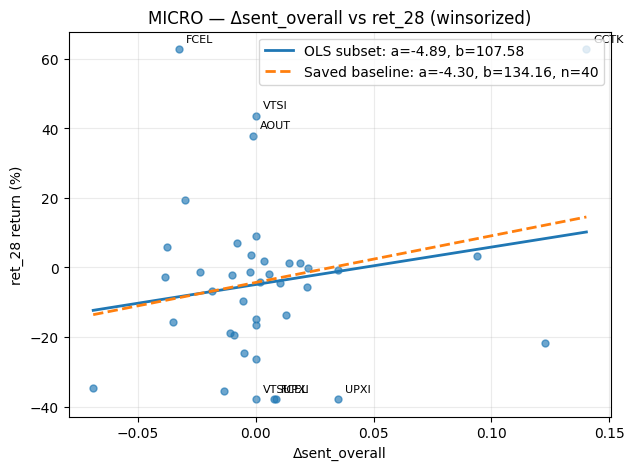

,ticker,filing_date,Δsent_overall,ret_28,ret_28_w,_resid,resid_abs
54,FCEL,2025-09-09,-0.032653,96.718147,62.788010,71.187075,71.187075
27,GCTK,2024-08-13,0.140295,91.980393,62.788010,52.580831,52.580831
31,VTSI,2025-05-12,0.000000,43.683084,43.683084,48.569199,48.569199
50,AOUT,2024-12-05,-0.001177,37.889908,37.889908,42.902662,42.902662
21,UPXI,2024-07-09,0.034760,-38.733658,-37.829417,-36.682861,36.682861
22,UPXI,2024-02-14,0.008489,-61.413043,-37.829417,-33.856588,33.856588
56,FCEL,2025-03-11,0.007627,-40.320122,-37.829417,-33.763853,33.763853
34,VTSI,2024-05-14,0.000000,-50.578915,-37.829417,-32.943301,32.943301


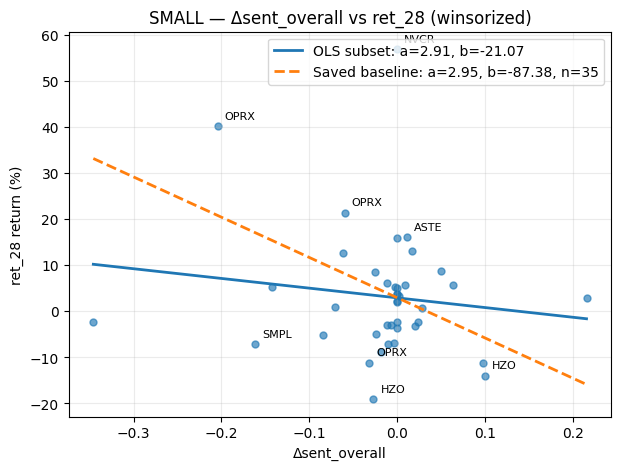

,ticker,filing_date,Δsent_overall,ret_28,ret_28_w,_resid,resid_abs
94,NVCR,2024-05-02,0.000002,56.941508,56.941508,54.032133,54.032133
43,OPRX,2025-05-13,-0.204029,40.236149,40.236149,33.028247,33.028247
3,HZO,2024-07-25,-0.026818,-19.083558,-19.083558,-22.557975,22.557975
44,OPRX,2024-11-14,-0.059721,21.428571,21.428571,17.260964,17.260964
2,HZO,2025-01-23,0.099752,-13.994439,-13.994439,-14.802263,14.802263
46,OPRX,2024-05-15,-0.031948,-11.161731,-11.161731,-14.744213,14.744213
150,ASTE,2025-08-06,0.011798,16.124937,16.124937,13.464081,13.464081
99,SMPL,2024-06-27,-0.161628,-7.088820,-7.088820,-13.403415,13.403415


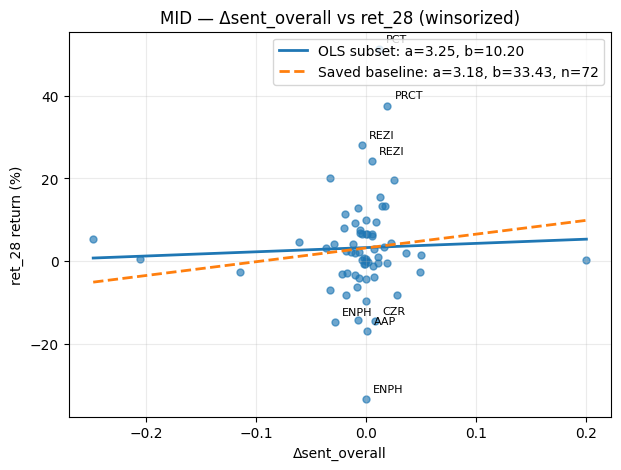

,ticker,filing_date,Δsent_overall,ret_28,ret_28_w,_resid,resid_abs
175,PCT,2025-05-07,0.011617,51.371951,51.371951,47.999412,47.999412
225,ENPH,2024-10-22,-0.000073,-33.470671,-33.470671,-36.723920,36.723920
117,PRCT,2024-08-02,0.019136,37.678634,37.678634,34.229368,34.229368
144,REZI,2025-08-05,-0.004054,28.097598,28.097598,24.884970,24.884970
146,REZI,2024-11-07,0.005051,24.137931,24.137931,20.832391,20.832391
255,AAP,2024-08-22,0.000283,-16.966732,-16.966732,-20.223615,20.223615
261,CZR,2024-10-29,0.007948,-14.575972,-14.575972,-17.911071,17.911071
223,ENPH,2025-07-22,-0.028956,-14.752941,-14.752941,-17.711456,17.711456


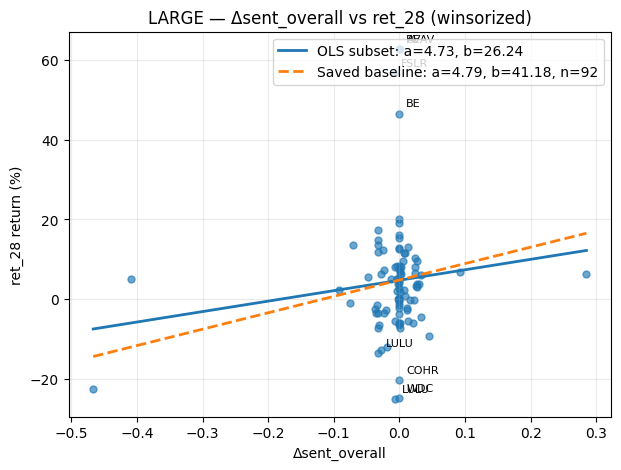

,ticker,filing_date,Δsent_overall,ret_28,ret_28_w,_resid,resid_abs
111,BE,2024-11-07,-0.000061,143.298969,62.788010,58.058929,58.058929
126,AVAV,2025-09-10,0.000370,64.950415,62.788010,58.047636,58.047636
202,FSLR,2024-05-01,-0.008741,56.656155,56.656155,52.154845,52.154845
109,BE,2025-07-31,-0.000048,46.563252,46.563252,41.833851,41.833851
181,LULU,2025-06-05,-0.006696,-25.122438,-25.122438,-29.677399,29.677399
247,WDC,2025-01-31,-0.000037,-24.873330,-24.873330,-29.603025,29.603025
277,COHR,2025-02-05,0.000028,-20.266371,-20.266371,-24.997774,24.997774
180,LULU,2025-09-04,-0.031944,-13.532923,-13.532923,-17.425409,17.425409


In [88]:
# === Visual check for micro/small buckets: scatter + baseline line + outlier labels ===
import json, math, matplotlib.pyplot as plt

HORIZON = "ret_28"   # change to "ret_7" if you want 7-day
CSV_PATH = BACKTEST_CSV
BASE_JSON = BASELINES_JSON

def _winsorize(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

# 1) Load backtest rows and rebuild Δsent_overall
df = pd.read_csv(CSV_PATH)
df["filing_date"] = pd.to_datetime(df["filing_date"])
df = df.sort_values(["ticker","filing_date"])
df["Δsent_overall"] = df.groupby("ticker")["sent_overall"].diff()

# 2) Attach market caps + buckets (light Polygon calls; NOT re-scraping filings)
#    (Reuses your polygon_market_cap + cap_bucket helpers defined earlier)
mc_map = {t: polygon_market_cap(t) for t in df["ticker"].unique()}
df["market_cap"] = df["ticker"].map(mc_map)
df["bucket"] = df["market_cap"].map(cap_bucket)

# 3) Pick bucket subset(s) and winsorize returns to reduce distortion
use = df.dropna(subset=["Δsent_overall", HORIZON]).copy()
use[HORIZON+"_w"] = _winsorize(use[HORIZON], p=0.01)

# 4) Load saved baselines (so we can plot the learned line on top)
with open(BASE_JSON, "r") as f:
    base = json.load(f)

def _plot_bucket(bucket_name):
    d = use[use["bucket"] == bucket_name].dropna(subset=["Δsent_overall", HORIZON+"_w"]).copy()
    if d.empty:
        print(f"[info] No rows for bucket={bucket_name}")
        return

    # OLS on this subset
    X = np.c_[np.ones(len(d)), d["Δsent_overall"].values]
    y = d[HORIZON+"_w"].values
    beta = np.linalg.pinv(X).dot(y)
    a_hat, b_hat = float(beta[0]), float(beta[1])

    # Residuals as a Series aligned to d's index
    y_hat = a_hat + b_hat * d["Δsent_overall"].values
    resid = pd.Series(y - y_hat, index=d.index, name="_resid")

    # Top outliers by |resid|
    out_idx = resid.abs().sort_values(ascending=False).head(8).index
    out = d.loc[out_idx].copy()
    out["_resid"] = resid.loc[out_idx]

    # Saved baseline line
    saved = base.get(bucket_name, {}).get("ret28" if HORIZON == "ret_28" else "ret7", {})
    a0 = saved.get("intercept", np.nan)
    b0 = saved.get("slope", np.nan)
    n0 = saved.get("n", 0)

    # Plot
    plt.figure(figsize=(7, 5))
    plt.scatter(d["Δsent_overall"], d[HORIZON+"_w"], s=25, alpha=0.65)
    xs = np.linspace(d["Δsent_overall"].min(), d["Δsent_overall"].max(), 200)

    # This-subset OLS fit
    plt.plot(xs, a_hat + b_hat * xs, linewidth=2, label=f"OLS subset: a={a_hat:.2f}, b={b_hat:.2f}")

    # Saved baseline fit (if available)
    if np.isfinite(a0) and np.isfinite(b0):
        plt.plot(xs, a0 + b0 * xs, linestyle="--", linewidth=2,
                 label=f"Saved baseline: a={a0:.2f}, b={b0:.2f}, n={n0}")

    plt.title(f"{bucket_name.upper()} — Δsent_overall vs {HORIZON} (winsorized)")
    plt.xlabel("Δsent_overall")
    plt.ylabel(f"{HORIZON} return (%)")
    plt.grid(True, alpha=0.25)
    plt.legend(loc="best")

    # Annotate top outliers
    for _, r in out.iterrows():
        plt.annotate(r["ticker"], (r["Δsent_overall"], r[HORIZON+"_w"]),
                     xytext=(5, 5), textcoords="offset points", fontsize=8)

    plt.show()

    # Table of those outliers
    display(
        out[["ticker", "filing_date", "Δsent_overall", HORIZON, HORIZON+"_w", "_resid"]]
        .assign(resid_abs=lambda x: x["_resid"].abs())
        .sort_values("resid_abs", ascending=False)
    )

# 5) Generate plots for micro and small
_plot_bucket("micro")
_plot_bucket("small")
_plot_bucket("mid")
_plot_bucket("large")

### Run Predictions on Given Ticker

In [89]:
# Assuming you already ran the cells that define run_predict() etc.
ticker = "WHR"  # <-- set your ticker symbol

pred = run_predict([ticker], w_short="auto", suggest_spread=False).iloc[0].to_dict()
print("sector:", pred["sector_used"], "| cap bucket:", pred["cap_bucket"], "| w_short:", pred["w_short"])

def print_valuation_summary(pred: dict):
    print("=== Prediction Summary ===")
    print(f"Ticker: {pred.get('ticker', '—')}")
    print(f"Cap bucket: {pred.get('cap_bucket', '—')} | Market cap: {pred.get('market_cap', '—'):,}")
    print(f"Asent_overall: {pred.get('asent_overall', float('nan')):.4f}")
    print(f"Pred 7d: {pred.get('pred_ret_7d_pct', float('nan')):.2f}% | Pred 28d: {pred.get('pred_ret_28d_pct', float('nan')):.2f}%")
    print(f"Price now: {pred.get('price_now', float('nan')):.2f}")

    # renamed keys here:
    if 'dcf_static' in pred:
        print(f"DCF (static) fair value: {pred['dcf_static']:.2f}")
    if 'multiples_mid' in pred:
        print(f"Multiples mid: {pred['multiples_mid']:.2f}")
    if 'price_28d_target' in pred:
        print(f"28d target: {pred['price_28d_target']:.2f}")

    # dynamic DCF diagnostics (new fields)
    if 'dcf_bands' in pred:
        b = pred['dcf_bands']
        print(f"DCF bands — Low: {b.get('low','—'):.2f} | Mid: {b.get('mid','—'):.2f} | High: {b.get('high','—'):.2f}")
    if 'disc_rate_r' in pred:
        print(f"r: {pred['disc_rate_r']:.2%} | g: {pred.get('growth_g', float('nan')):.2%} | g_term: {pred.get('terminal_g', float('nan')):.2%} | vol_ann: {pred.get('vol_annual', float('nan')):.2%}")

    # final blend
    if 'final_blended_target' in pred:
        print(f"Final blended target: {pred['final_blended_target']:.2f}, {pred.get('final_direction','—')}")

    # optional options suggestion
    ov = pred.get("options_vertical")
    if ov:
        print("\n== Suggested Options Vertical ==")
        print(f"Type: {ov.get('type','—')}  |  Exp: {ov.get('expiration','—')}")
        print(f"Buy: {ov.get('buy_strike','—')}  |  Sell: {ov.get('sell_strike','—')}")
        print(f"Debit: {ov.get('debit','—')}  |  Width: {ov.get('width','—')}  |  Max Profit: {ov.get('max_profit','—')}")
        print(f"R:R (profit/risk): {ov.get('R_by_Risk','—')}")
    else:
        print("\n(No options suggestion — ensure TRADIER_ACCESS_TOKEN is set and chains are available.)")

# call it
print_valuation_summary(pred)

ov = pred.get("options_vertical")
if ov:
    print("\n=== Suggested Options Vertical ===")
    print(f"Type: {ov['type']}  |  Exp: {ov['expiration']}")
    print(f"Buy {ov['buy_strike']}  /  Sell {ov['sell_strike']}")
    print(f"Debit: {ov['debit']}  |  Width: {ov['width']}  |  Max Profit: {ov['max_profit']}")
    print(f"R:R (profit/risk): {ov['R_by_Risk']}")
else:
    print("\n(No options suggestion – ensure TRADIER_ACCESS_TOKEN is set and chains are available.)")


Device set to use cpu


[warn] EPS*Shares != NetIncome by >15%. Check tags/periods.
sector: Consumer Discretionary | cap bucket: mid | w_short: 0.45
=== Prediction Summary ===
Ticker: WHR
Cap bucket: mid | Market cap: 4,336,288,172.64
Asent_overall: 0.0000
Pred 7d: 0.91% | Pred 28d: 3.18%
Price now: 77.58
DCF (static) fair value: -143.25
Multiples mid: 340.17
28d target: 80.05
DCF bands — Low: -60.02 | Mid: -71.78 | High: -88.60
r: 15.50% | g: 1.53% | g_term: 2.00% | vol_ann: 39.05%
Final blended target: 109.83, UP

(No options suggestion — ensure TRADIER_ACCESS_TOKEN is set and chains are available.)

(No options suggestion – ensure TRADIER_ACCESS_TOKEN is set and chains are available.)
